# GPLearn for Image Synthesis

## Imports

In [1]:
from gplearn.genetic import SymbolicRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import graphviz
from sklearn.metrics import make_scorer
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from gplearn.fitness import make_fitness
import os
import pickle
import sys
from utils.comparison import *
import contextlib
from PIL import Image

In [2]:
GENERATIONS= 30
POP_SIZE = 50

## Data

In [3]:
def safe_exp_exp(val):
    val = np.where(val > 700, 700, val)
    return np.exp(-np.exp(val))

def precalculate_xy(x, y):
    x2_y2 = x**2 + y**2
    sin_x = np.sin(x)
    cos_y = np.cos(y)
    sin_03x_07y = np.sin(0.3 * x - 0.7 * y)
    sin_03x_05y = np.sin(0.3 * x + 0.5 * y)
    return {
        "x2_y2": x2_y2,
        "sin_x": sin_x,
        "cos_y": cos_y,
        "sin_combo1": sin_03x_07y,
        "sin_combo2": sin_03x_05y
    }

def precalculate_D_B(cache):
    D_val = safe_exp_exp(cache["x2_y2"] - 1089)
    B_val = safe_exp_exp(cache["x2_y2"] - 1225) * \
            safe_exp_exp(-1000 * (cache["sin_combo1"] + 4 * cache["sin_combo2"]))
    return D_val, B_val

def Jc(D_val, B_val, cache, c):
    poly = -0.07 * c**2 + 0.18 * c + 0.88
    exp1 = safe_exp_exp(cache["x2_y2"] - (cache["x2_y2"] - cache["x2_y2"] + 20_000))
    exp2 = safe_exp_exp(-20 * (cache["sin_x"] + cache["cos_y"]))
    return (1 - D_val) * (1 - B_val) * poly * exp1 * exp2

def Ic(D_val, B_val, cache, c):
    poly = -0.02 * c**2 + 0.23 * c + 0.04
    exp = safe_exp_exp(10 * (cache["sin_x"] + cache["cos_y"]))
    return (1 - D_val) * (1 - B_val) * poly * exp

def Hc(D_val, B_val, c):
    poly = 0.15 * c**2 - 0.76 * c + 1.6
    return poly * B_val + (1 - B_val) * 0.93 * D_val

def Ac(x, y, c):
    cache = precalculate_xy(x, y)
    D_val, B_val = precalculate_D_B(cache)
    return 255 * (Hc(D_val, B_val, c) + Ic(D_val, B_val, cache, c) + Jc(D_val, B_val, cache, c))

def rgb(x, y, c):
    return Ac((x - 800) / 10, (500 - y) / 10, c)

In [4]:
width, height = 1600, 1000

m = np.linspace(1, width, width//5)
n = np.linspace(1, height, height//5)
m_grid, n_grid = np.meshgrid(m, n)

r = rgb(m_grid, n_grid, 1)
g = rgb(m_grid, n_grid, 2)
b = rgb(m_grid, n_grid, 3)

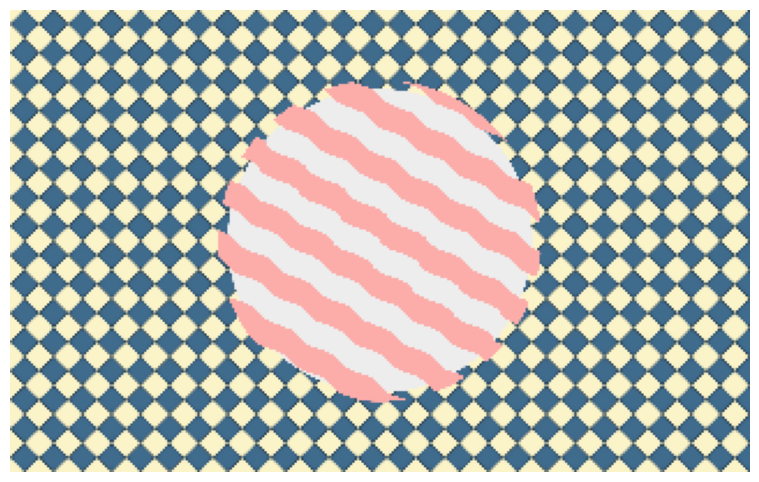

In [5]:
rgb_image = np.stack([r, g, b], axis=-1).astype(np.uint8)

plt.figure(figsize=(10, 6))
plt.imshow(rgb_image)
plt.axis('off')
plt.savefig('data/hard_2.png')
plt.show()

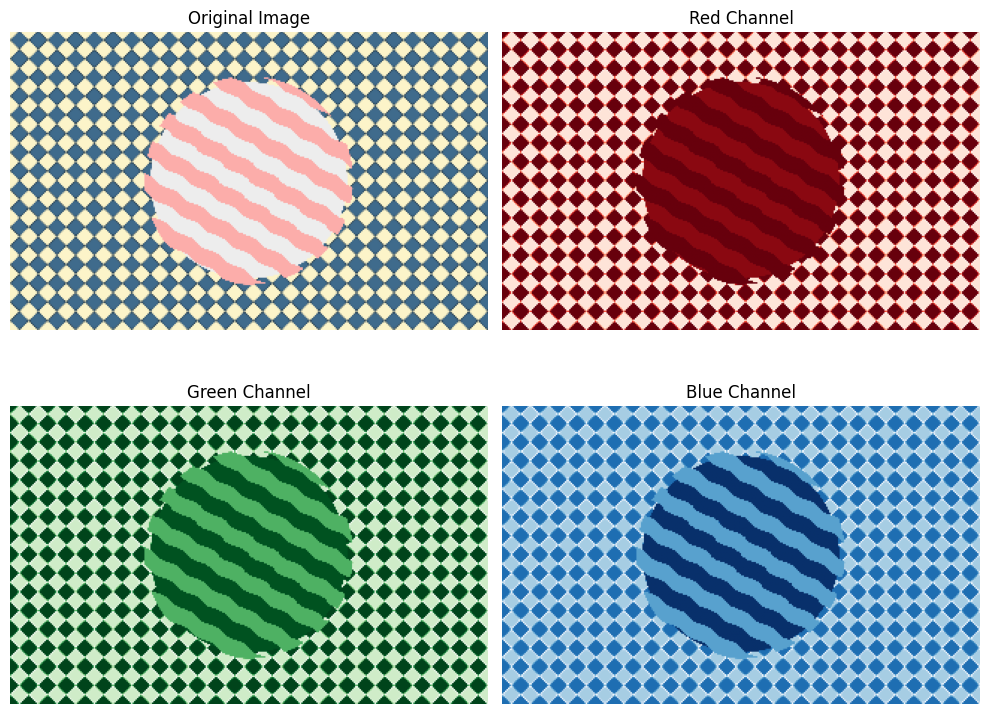

In [6]:
plt.figure(figsize=(10, 8))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(rgb_image)
plt.title('Original Image')
plt.axis('off')

# Red channel
plt.subplot(2, 2, 2)
plt.imshow(r, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

# Green channel
plt.subplot(2, 2, 3)
plt.imshow(g, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

# Blue channel
plt.subplot(2, 2, 4)
plt.imshow(b, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

## Experiments

In [7]:
@contextlib.contextmanager
def suppress_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stderr = os.dup(2)
        os.dup2(devnull.fileno(), 2)
        try:
            yield
        finally:
            os.dup2(old_stderr, 2)
            os.close(old_stderr)

In [8]:
np.seterr(divide='ignore', invalid='ignore')

def safe_sin(x):
    return np.sin(np.clip(x, -1e3, 1e3))

def safe_cos(x):
    return np.cos(np.clip(x, -1e3, 1e3))

def safe_square(x):
    return np.clip(x, -1e3, 1e3) ** 2

def safe_cube(x):
    return np.clip(x, -1e3, 1e3) ** 3

exp_exp = make_function(function=safe_exp_exp, name="exp_exp", arity=1)
sin = make_function(function=safe_sin, name="sin", arity=1)
cos = make_function(function=safe_cos, name="cos", arity=1)
square = make_function(function=safe_square, name="square", arity=1)
cube = make_function(function=safe_cube, name="cube", arity=1)

function_set = ['add', 'sub', 'mul', sin, cos, square, cube, exp_exp]

est_r = SymbolicRegressor(metric="mean absolute error", function_set=function_set, population_size=POP_SIZE, generations=GENERATIONS, stopping_criteria=0.0,
        verbose=1, random_state=42, n_jobs=2, init_method='half and half', const_range = (-1, 1))

est_g = SymbolicRegressor(metric="mean absolute error", function_set=function_set, population_size=POP_SIZE, generations=GENERATIONS, stopping_criteria=0.0,
        verbose=1, random_state=42, n_jobs=2, init_method='half and half', const_range = (-1, 1))

est_b = SymbolicRegressor(metric="mean absolute error", function_set=function_set, population_size=POP_SIZE, generations=GENERATIONS, stopping_criteria=0.0,
        verbose=1, random_state=42, n_jobs=2, init_method='half and half', const_range = (-1, 1))

H, W, _ = rgb_image.shape

arr = []

x = np.arange(1, W + 1)
y = np.arange(1, H + 1)
X, Y = np.meshgrid(x, y)
xy_train = np.stack([X.ravel(), Y.ravel()], axis=1)

r_train = xy_train
g_train = xy_train
b_train = xy_train

r = r.flatten()
g = g.flatten()
b = b.flatten()

print(f"Training Red: \n")
est_r.fit(r_train, r)

print(f"Training Green: \n")
est_g.fit(g_train, g)

print(f"Training Blue: \n")
est_b.fit(b_train, b)

Training Red: 

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   0    11.24       1.1248e+09        6          105.409              N/A     34.10s
   1     7.60          3050.62        5          105.294              N/A      4.21s
   2     5.76          129.314       15          105.216              N/A      3.29s
   3     8.08          654.904       12          105.215              N/A      3.33s
   4    12.84          18446.9       16          105.125              N/A      4.32s
   5    15.70          3579.94       24          104.953              N/A      4.42s
   6    15.88          2330.03       20          104.946              N/A      4.74s
   7    22.60          3183.02       39          104.617              N/A      5.55s
   8    29.32          16282.9       49           104.39              N/A      5.64s
   9    46.20          2060.49       76          103.938              N/A      8.30s
  10    58.08          21101.8       84          103.756              N/A      9.09s
  11    81.00          3111.45      122           103.41         

/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     7.60          3044.24        5          91.6051              N/A      3.42s
   2     5.76          120.003       15          91.5253              N/A      3.03s
   3     8.08          645.228       12          91.5242              N/A      3.63s
   4    12.84          18439.3       16          91.4334              N/A      3.77s
   5    15.70           3572.1       24          91.2597              N/A      4.40s
   6    15.88          2321.19       20          91.2517              N/A      4.92s
   7    22.60          3176.61       39          90.9228              N/A      5.26s
   8    29.32          16274.2       49             90.7              N/A      5.43s
   9    46.20          2051.98       76          90.2792              N/A      7.30s
  10    58.08          21094.1       84          90.1136              N/A      8.63s
  11    81.00          3101.65      122          89.8611              N/A     11.47s
  12   104.64          3108.52      157          89.8169         

/home/mati/image-synthesis/image-synthesis-venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   1     8.06          4631.65       11          84.3589              N/A      3.00s
   2    11.76           881.04        1          83.8915              N/A      3.85s
   3    12.78          1159.68       16          83.7861              N/A      3.73s
   4    12.84          909.241        5          83.5299              N/A      4.22s
   5     9.56          885.321        4           83.437              N/A      3.41s
   6     4.28          377.779        7          82.9836              N/A      2.14s
   7     5.02          650.457        7          82.9836              N/A      1.56s
   8     6.66          376.398       10          82.5356              N/A      1.58s
   9     9.30          640.762       13          82.0917              N/A      1.54s
  10    11.38          1326.56       19          81.2171              N/A      1.67s
  11    17.12          371.057       28          79.9306              N/A      2.00s
  12    24.98          110.437       46          77.4384         

SymbolicRegressor(const_range=(-1, 1),
                  function_set=['add', 'sub', 'mul',
                                <gplearn.functions._Function object at 0x7afaa5148260>,
                                <gplearn.functions._Function object at 0x7afaa50b1070>,
                                <gplearn.functions._Function object at 0x7afaa5173380>,
                                <gplearn.functions._Function object at 0x7afaa5170530>,
                                <gplearn.functions._Function object at 0x7afad77c3080>],
                  generations=30, n_jobs=2, population_size=50, random_state=42,
                  verbose=1)

## Results

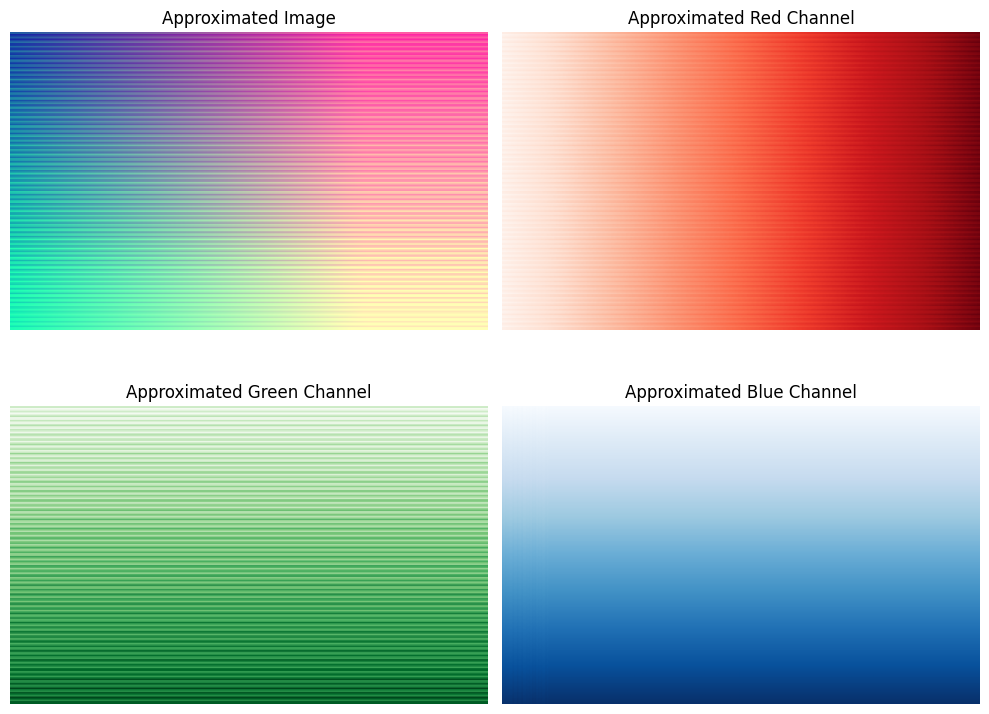

In [9]:
r_pred = est_r.predict(xy_train).reshape(H, W)
g_pred = est_g.predict(xy_train).reshape(H, W)
b_pred = est_b.predict(xy_train).reshape(H, W)

rgb_pred = np.stack([r_pred, g_pred, b_pred], axis=-1)
rgb_pred = np.clip(rgb_pred, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(rgb_pred)
plt.title('Approximated Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(r_pred, cmap='Reds')
plt.title('Approximated Red Channel')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(g_pred, cmap='Greens')
plt.title('Approximated Green Channel')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(b_pred, cmap='Blues')
plt.title('Approximated Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
print(est_r._program)

add(add(0.553, add(add(0.553, add(add(0.553, add(0.553, add(add(0.553, add(add(add(0.553, add(add(add(add(add(0.553, add(0.553, add(add(add(add(add(add(0.553, add(0.553, add(add(add(add(0.553, add(0.553, add(add(0.553, add(0.553, add(add(add(add(add(0.553, add(add(add(0.553, add(add(add(0.553, add(add(add(add(X0, exp_exp(mul(sin(X1), X1))), square(sin(X1))), square(sin(X1))), square(cos(X1)))), square(sin(add(add(add(add(0.553, add(0.553, add(add(0.553, add(0.553, add(add(add(add(add(0.553, add(add(add(0.553, add(add(add(add(0.553, add(add(add(add(X0, exp_exp(mul(sin(X1), X1))), square(sin(X1))), square(sin(X1))), square(cos(X1)))), square(sin(X1))), square(sin(X1))), square(sin(X1)))), sin(X1)), square(sin(X1)))), sin(X1)), square(sin(X1))), square(sin(X1))), square(sin(X1))))), square(sin(X1))))), square(sin(X1))), square(sin(X1))), square(sin(X1)))))), square(sin(X1)))), sin(X1)), square(sin(X1)))), sin(X1)), square(cos(X1))), square(sin(X1))), square(sin(X1))))), square(sin(X1)))))

In [11]:
print(est_g._program)

add(add(0.553, add(add(0.553, add(0.553, add(add(0.553, add(add(add(0.553, add(add(add(add(add(0.553, add(0.553, add(add(add(add(add(add(add(add(0.553, add(add(0.553, add(0.553, add(add(0.553, add(add(add(0.553, add(0.553, add(add(add(add(add(0.553, add(0.553, add(add(add(0.553, add(add(add(add(add(0.553, add(0.553, add(add(add(add(add(add(0.553, add(0.553, add(add(0.553, add(0.553, add(add(0.553, add(0.553, add(add(add(0.553, add(0.553, add(add(0.553, add(0.553, add(add(add(add(add(0.553, add(0.553, add(add(add(add(add(add(0.553, add(0.553, add(add(0.553, add(0.553, add(add(0.553, add(0.553, add(add(add(0.553, add(0.553, add(add(0.553, add(0.553, add(add(add(add(add(0.553, add(0.553, add(add(0.553, add(add(add(0.553, add(0.553, add(add(add(add(add(0.553, add(0.553, add(add(add(0.553, add(add(add(add(add(0.553, add(0.553, add(add(add(add(add(add(0.553, add(0.553, add(add(0.553, add(0.553, add(add(add(add(add(0.553, X1), square(sin(X1))), square(sin(X1))), square(sin(X1))), square(sin(X

In [12]:
print(est_b._program)

add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(mul(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(mul(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(add(

In [13]:
dot_data = est_r._program.export_graphviz()
graph = graphviz.Source(dot_data)
#graph

In [14]:
dot_data = est_g._program.export_graphviz()
graph = graphviz.Source(dot_data)
#graph

In [15]:
dot_data = est_b._program.export_graphviz()
graph = graphviz.Source(dot_data)
#graph

In [16]:
est_r.run_details_.keys()

dict_keys(['generation', 'average_length', 'average_fitness', 'best_length', 'best_fitness', 'best_oob_fitness', 'generation_time'])

In [17]:
est_g.run_details_.keys()

dict_keys(['generation', 'average_length', 'average_fitness', 'best_length', 'best_fitness', 'best_oob_fitness', 'generation_time'])

In [18]:
est_b.run_details_.keys()

dict_keys(['generation', 'average_length', 'average_fitness', 'best_length', 'best_fitness', 'best_oob_fitness', 'generation_time'])